# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                    
Sample_095  P26038                               15.908
Sample_068  Q13790                               14.015
Sample_011  J3KSN0;J3KTR4;J3QKK2;J3QQU6;Q8WVN6   16.631
Sample_145  H0YNK6;Q06418                        17.790
Sample_182  Q9H8L6                               16.898
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups               
Sample_189  O75874                          13.550
Sample_017  P16083;Q5TD07                   14.406
Sample_169  E5RK69;E7EMC6;P08133;P08133-2   12.894
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.052
            A0A075B6Q5                 12.273
            A0A075B6R2                 12.421
            A0A075B6S5                 13.466
            A0A087WSY4                 12.732
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.578
            Q9UI40;Q9UI40-2            13.418
            Q9UIW2                     12.476
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.991
            Q9UP79                     13.327
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.705,15.050,16.842,19.863,15.792,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.199,19.067,...,15.528,15.576,13.871,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.942,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.688,17.705,17.039,16.281,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.583,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.515,15.345,17.084,18.708,14.249,19.433,12.278,11.589
Sample_207,15.739,16.877,15.469,16.898,15.227,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.052,...,16.012,15.178,13.863,15.050,16.842,19.863,13.050,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.950,19.067,16.188,...,15.528,15.576,12.754,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.012,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.919,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.758,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.896,15.345,17.084,18.708,14.249,19.433,13.065,13.373
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 463.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.30it/s]

100%|██████████| 3/3 [00:00<00:00,  3.68it/s]

100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.80it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.14it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.04it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.47it/s]

100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.93it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.34it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.14it/s]

100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.23it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.56it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.78it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.44it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.10it/s]

100%|██████████| 7/7 [00:02<00:00,  2.96it/s]

100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.79it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.20it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.53it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.29it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.05it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.84it/s]

100%|██████████| 8/8 [00:02<00:00,  2.87it/s]

100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.98it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.84it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.40it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.32it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.19it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.19it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.14it/s]

100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

100%|██████████| 9/9 [00:02<00:00,  3.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.57it/s]

 30%|███       | 3/10 [00:00<00:01,  3.94it/s]

 40%|████      | 4/10 [00:01<00:01,  3.48it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.27it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.23it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.15it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.06it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.03it/s]

100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.23it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.11it/s]

 36%|███▋      | 4/11 [00:01<00:03,  1.86it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.96it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.91it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.93it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.15it/s]

 82%|████████▏ | 9/11 [00:04<00:00,  2.36it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.52it/s]

100%|██████████| 11/11 [00:04<00:00,  2.63it/s]

100%|██████████| 11/11 [00:04<00:00,  2.27it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.88it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.68it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.25it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.04it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.89it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.42it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.11it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  1.86it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.79it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.71it/s]

100%|██████████| 12/12 [00:05<00:00,  1.83it/s]

100%|██████████| 12/12 [00:05<00:00,  2.21it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  2.82it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.24it/s]

 31%|███       | 4/13 [00:01<00:04,  1.97it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.27it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.37it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.46it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.35it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.49it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.55it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.60it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.64it/s]

100%|██████████| 13/13 [00:05<00:00,  2.81it/s]

100%|██████████| 13/13 [00:05<00:00,  2.50it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.28it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.68it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.40it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.32it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.11it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.80it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.26it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  1.82it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.63it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.64it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.70it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.85it/s]

100%|██████████| 14/14 [00:06<00:00,  2.10it/s]

100%|██████████| 14/14 [00:06<00:00,  2.22it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.36it/s]

 20%|██        | 3/15 [00:01<00:05,  2.17it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.10it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.94it/s]

 40%|████      | 6/15 [00:02<00:04,  2.08it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.22it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.18it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.26it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.28it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.31it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.24it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.45it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.52it/s]

100%|██████████| 15/15 [00:06<00:00,  2.62it/s]

100%|██████████| 15/15 [00:06<00:00,  2.33it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.045 0.006          0.731 0.364       0.117   
2             0.004 0.000      0.047 0.001          0.635 0.141       0.460   
3             0.004 0.000      0.048 0.002          0.818 0.075       0.706   
4             0.004 0.000      0.047 0.001          0.810 0.085       0.763   
5             0.004 0.002      0.048 0.002          0.823 0.084       0.773   
6             0.004 0.000      0.048 0.005          0.820 0.084       0.772   
7             0.004 0.000      0.047 0.002          0.814 0.088       0.770   
8             0.004 0.000      0.047 0.004          0.810 0.084       0.835   
9             0.004 0.000      0.047 0.002          0.814 0.088       0.829   
10            0.005 0.004      0.050 0.017          0.817 0.085       0.827   
11            0.007 0.005      0.081 0.035          0.822 0.084       0.861   
12            0.004 0.001      0.051 0.010          0.829 0.079       0.859   
13            0.006 0.005      0.076 0.030          0.815 0.078       0.859   
14            0.004 0.002      0.053 0.018          0.836 0.085       0.824   
15            0.006 0.004      0.063 0.028          0.825 0.082       0.822   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.194 0.133                  0.551 0.042        0.855   
2          0.114   0.523 0.100                  0.627 0.068        0.703   
3          0.100   0.753 0.068                  0.794 0.053        0.898   
4          0.103   0.780 0.068                  0.814 0.057        0.909   
5          0.102   0.793 0.072                  0.824 0.061        0.914   
6          0.101   0.791 0.071                  0.822 0.060        0.912   
7          0.122   0.785 0.084                  0.819 0.068        0.912   
8          0.102   0.818 0.072                  0.844 0.062        0.923   
9          0.105   0.817 0.074                  0.843 0.063        0.920   
10         0.107   0.817 0.074                  0.844 0.063        0.921   
11         0.101   0.837 0.073                  0.861 0.063        0.925   
12         0.100   0.840 0.070                  0.863 0.060        0.924   
13         0.099   0.834 0.071                  0.858 0.061        0.921   
14         0.105   0.826 0.076                  0.851 0.064        0.929   
15         0.103   0.819 0.074                  0.846 0.062        0.928   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.827 0.092        210.000 0.000  
2          0.084                  0.654 0.100        210.000 0.000  
3          0.046                  0.876 0.058        210.000 0.000  
4          0.043                  0.885 0.053        210.000 0.000  
5          0.045                  0.894 0.055        210.000 0.000  
6          0.047                  0.892 0.057        210.000 0.000  
7          0.049                  0.892 0.060        210.000 0.000  
8          0.044                  0.909 0.049        210.000 0.000  
9          0.045                  0.904 0.052        210.000 0.000  
10         0.046                  0.905 0.053        210.000 0.000  
11         0.043                  0.909 0.049        210.000 0.000  
12         0.043                  0.908 0.050        210.000 0.000  
13         0.044                  0.906 0.050        210.000 0.000  
14         0.041                  0.915 0.048        210.000 0.000  
15         0.039                  0.915 0.046 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 452.56it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.67it/s]

100%|██████████| 3/3 [00:00<00:00,  2.94it/s]

100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.66it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.43it/s]

100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.12it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.23it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.06it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.30it/s]

 67%|██████▋   | 4/6 [00:01<00:01,  1.76it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.58it/s]

100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

100%|██████████| 6/6 [00:03<00:00,  1.77it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  2.84it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.11it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.05it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.99it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.95it/s]

100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.60it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.88it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.74it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.23it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.88it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.77it/s]

100%|██████████| 8/8 [00:03<00:00,  1.79it/s]

100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.13it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.64it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.42it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.42it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.45it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.38it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.27it/s]

100%|██████████| 9/9 [00:03<00:00,  2.04it/s]

100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.40it/s]

 30%|███       | 3/10 [00:00<00:02,  2.87it/s]

 40%|████      | 4/10 [00:01<00:02,  2.59it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.47it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.47it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.35it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.28it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.29it/s]

100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.55it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.13it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.37it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.08it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.02it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.67it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.62it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.55it/s]

100%|██████████| 11/11 [00:05<00:00,  1.73it/s]

100%|██████████| 11/11 [00:05<00:00,  1.91it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.84it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.07it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.78it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.66it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.57it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.52it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.41it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.45it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.12it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.92it/s]

100%|██████████| 12/12 [00:05<00:00,  1.86it/s]

100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.51it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.00it/s]

 31%|███       | 4/13 [00:01<00:04,  2.25it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.03it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.91it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.94it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.76it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.59it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.50it/s]

 85%|████████▍ | 11/13 [00:06<00:01,  1.49it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.62it/s]

100%|██████████| 13/13 [00:06<00:00,  1.85it/s]

100%|██████████| 13/13 [00:06<00:00,  1.86it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.10it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.71it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.40it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.21it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.10it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.15it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.14it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.19it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.18it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.28it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.07it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.87it/s]

100%|██████████| 14/14 [00:06<00:00,  1.74it/s]

100%|██████████| 14/14 [00:06<00:00,  2.08it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.27it/s]

 20%|██        | 3/15 [00:00<00:03,  3.56it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.81it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.37it/s]

 40%|████      | 6/15 [00:02<00:04,  2.11it/s]

 47%|████▋     | 7/15 [00:02<00:04,  1.96it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.94it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.99it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.74it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.61it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.52it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.57it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.68it/s]

100%|██████████| 15/15 [00:07<00:00,  1.83it/s]

100%|██████████| 15/15 [00:07<00:00,  1.95it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.054 0.023          0.000 0.000       0.000   
2             0.005 0.004      0.067 0.028          0.726 0.096       0.470   
3             0.006 0.005      0.075 0.028          0.767 0.081       0.695   
4             0.004 0.002      0.067 0.024          0.771 0.088       0.710   
5             0.004 0.002      0.058 0.023          0.754 0.085       0.717   
6             0.004 0.002      0.064 0.030          0.799 0.092       0.763   
7             0.007 0.006      0.078 0.032          0.792 0.088       0.758   
8             0.006 0.005      0.075 0.028          0.796 0.085       0.762   
9             0.008 0.008      0.080 0.033          0.784 0.087       0.788   
10            0.006 0.005      0.080 0.029          0.798 0.093       0.786   
11            0.008 0.007      0.069 0.030          0.842 0.082       0.797   
12            0.006 0.006      0.071 0.029          0.838 0.083       0.799   
13            0.006 0.004      0.062 0.029          0.823 0.079       0.800   
14            0.008 0.006      0.091 0.031          0.855 0.078       0.827   
15            0.005 0.003      0.059 0.019          0.851 0.080       0.822   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.853   
2          0.124   0.558 0.095                  0.666 0.051        0.715   
3          0.108   0.724 0.080                  0.769 0.061        0.864   
4          0.103   0.734 0.072                  0.776 0.057        0.870   
5          0.122   0.729 0.083                  0.771 0.066        0.869   
6          0.102   0.775 0.070                  0.809 0.059        0.902   
7          0.101   0.769 0.070                  0.804 0.058        0.900   
8          0.099   0.774 0.071                  0.808 0.059        0.898   
9          0.113   0.781 0.079                  0.813 0.067        0.896   
10         0.113   0.787 0.082                  0.818 0.068        0.909   
11         0.092   0.815 0.066                  0.842 0.055        0.929   
12         0.092   0.814 0.067                  0.841 0.056        0.927   
13         0.092   0.808 0.064                  0.836 0.054        0.926   
14         0.091   0.837 0.063                  0.861 0.053        0.932   
15         0.093   0.832 0.062                  0.857 0.053        0.933   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.825 0.087        210.000 0.000  
2          0.074                  0.669 0.076        210.000 0.000  
3          0.052                  0.837 0.068        210.000 0.000  
4          0.051                  0.834 0.070        210.000 0.000  
5          0.050                  0.831 0.070        210.000 0.000  
6          0.050                  0.876 0.065        210.000 0.000  
7          0.049                  0.874 0.063        210.000 0.000  
8          0.049                  0.873 0.062        210.000 0.000  
9          0.052                  0.871 0.065        210.000 0.000  
10         0.048                  0.887 0.059        210.000 0.000  
11         0.039                  0.916 0.046        210.000 0.000  
12         0.040                  0.915 0.046        210.000 0.000  
13         0.041                  0.913 0.046        210.000 0.000  
14         0.039                  0.921 0.042        210.000 0.000  
15         0.038                  0.922 0.041 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 992.26it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 23.30it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 15.80it/s]

100%|██████████| 3/3 [00:00<00:00, 14.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 14.31it/s]

100%|██████████| 4/4 [00:00<00:00, 10.62it/s]

100%|██████████| 4/4 [00:00<00:00, 10.97it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.62it/s]

100%|██████████| 5/5 [00:00<00:00, 13.93it/s]

100%|██████████| 5/5 [00:00<00:00, 14.36it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 18.72it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 11.47it/s]

100%|██████████| 6/6 [00:00<00:00,  9.38it/s]

100%|██████████| 6/6 [00:00<00:00, 10.07it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 20.35it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 13.93it/s]

100%|██████████| 7/7 [00:00<00:00, 14.36it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 12.97it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  9.41it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  8.58it/s]

 88%|████████▊ | 7/8 [00:00<00:00,  8.74it/s]

100%|██████████| 8/8 [00:00<00:00,  8.25it/s]

100%|██████████| 8/8 [00:00<00:00,  8.77it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.95it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.33it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.60it/s]

100%|██████████| 9/9 [00:00<00:00, 10.53it/s]

100%|██████████| 9/9 [00:00<00:00, 11.25it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 18.40it/s]

 40%|████      | 4/10 [00:00<00:00, 13.12it/s]

 60%|██████    | 6/10 [00:00<00:00, 12.41it/s]

 80%|████████  | 8/10 [00:00<00:00, 11.67it/s]

100%|██████████| 10/10 [00:00<00:00, 10.85it/s]

100%|██████████| 10/10 [00:00<00:00, 11.62it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.02it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.28it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.68it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.43it/s]

100%|██████████| 11/11 [00:00<00:00, 11.59it/s]

100%|██████████| 11/11 [00:00<00:00, 11.75it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 14.52it/s]

 33%|███▎      | 4/12 [00:00<00:00, 10.52it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.07it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  8.33it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  8.95it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  9.03it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  9.19it/s]

100%|██████████| 12/12 [00:01<00:00,  9.43it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 12.23it/s]

 31%|███       | 4/13 [00:00<00:00, 11.19it/s]

 46%|████▌     | 6/13 [00:00<00:00, 11.60it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 10.06it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 10.36it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  9.86it/s]

100%|██████████| 13/13 [00:01<00:00, 10.49it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.71it/s]

 36%|███▌      | 5/14 [00:00<00:00, 11.24it/s]

 50%|█████     | 7/14 [00:00<00:00,  9.79it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.68it/s]

 71%|███████▏  | 10/14 [00:00<00:00,  9.42it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.48it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.18it/s]

100%|██████████| 14/14 [00:01<00:00,  9.45it/s]

100%|██████████| 14/14 [00:01<00:00,  9.90it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 17.09it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.39it/s]

 40%|████      | 6/15 [00:00<00:00,  9.55it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.84it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.70it/s]

 80%|████████  | 12/15 [00:01<00:00, 10.15it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 10.10it/s]

100%|██████████| 15/15 [00:01<00:00, 10.04it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.075 0.033          0.000 0.000       0.000   
2             0.005 0.003      0.058 0.020          0.670 0.122       0.507   
3             0.009 0.006      0.089 0.026          0.659 0.117       0.505   
4             0.004 0.002      0.059 0.021          0.626 0.103       0.510   
5             0.005 0.004      0.068 0.024          0.619 0.099       0.503   
6             0.005 0.006      0.065 0.025          0.717 0.074       0.618   
7             0.005 0.003      0.063 0.023          0.712 0.081       0.613   
8             0.007 0.005      0.074 0.027          0.702 0.081       0.620   
9             0.005 0.003      0.063 0.025          0.728 0.089       0.644   
10            0.007 0.006      0.078 0.029          0.733 0.086       0.649   
11            0.005 0.003      0.058 0.023          0.718 0.078       0.682   
12            0.007 0.007      0.079 0.029          0.711 0.074       0.674   
13            0.005 0.003      0.061 0.025          0.706 0.080       0.651   
14            0.006 0.005      0.083 0.032          0.705 0.079       0.647   
15            0.005 0.003      0.056 0.021          0.699 0.078       0.656   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.716   
2          0.110   0.569 0.094                  0.659 0.068        0.704   
3          0.105   0.565 0.090                  0.654 0.064        0.698   
4          0.111   0.554 0.086                  0.640 0.059        0.707   
5          0.112   0.547 0.085                  0.636 0.056        0.701   
6          0.113   0.655 0.071                  0.717 0.048        0.775   
7          0.107   0.652 0.075                  0.714 0.054        0.770   
8          0.113   0.653 0.081                  0.713 0.060        0.803   
9          0.113   0.677 0.082                  0.732 0.060        0.812   
10         0.116   0.682 0.084                  0.737 0.061        0.812   
11         0.113   0.694 0.080                  0.742 0.063        0.813   
12         0.117   0.686 0.079                  0.736 0.059        0.810   
13         0.112   0.672 0.082                  0.726 0.062        0.808   
14         0.109   0.670 0.081                  0.724 0.060        0.806   
15         0.106   0.671 0.074                  0.724 0.056        0.802   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.689 0.073        210.000 0.000  
2          0.078                  0.656 0.093        210.000 0.000  
3          0.078                  0.653 0.091        210.000 0.000  
4          0.075                  0.659 0.090        210.000 0.000  
5          0.075                  0.649 0.089        210.000 0.000  
6          0.053                  0.726 0.070        210.000 0.000  
7          0.053                  0.722 0.072        210.000 0.000  
8          0.060                  0.755 0.081        210.000 0.000  
9          0.057                  0.766 0.074        210.000 0.000  
10         0.057                  0.763 0.071        210.000 0.000  
11         0.057                  0.772 0.072        210.000 0.000  
12         0.057                  0.769 0.073        210.000 0.000  
13         0.060                  0.767 0.074        210.000 0.000  
14         0.059                  0.767 0.072        210.000 0.000  
15         0.061                  0.762 0.074 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,11,9,3
score_time,11,14,3
test_precision,14,14,10
test_recall,11,14,11
test_f1,12,14,11
test_balanced_accuracy,12,14,11
test_roc_auc,14,15,11
test_average_precision,14,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.85it/s]

 20%|██        | 3/15 [00:00<00:03,  3.17it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.58it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.48it/s]

 40%|████      | 6/15 [00:02<00:03,  2.38it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.43it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.24it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.29it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.26it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.30it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.35it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.14it/s]

100%|██████████| 15/15 [00:06<00:00,  2.24it/s]

100%|██████████| 15/15 [00:06<00:00,  2.40it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.65it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.67it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.16it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.23it/s]

100%|██████████| 11/11 [00:01<00:00,  9.74it/s]

100%|██████████| 11/11 [00:01<00:00, 10.74it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.86it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.00it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.09it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.03it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.08it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.07it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.64it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.60it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.70it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.77it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.79it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.81it/s]

100%|██████████| 14/14 [00:04<00:00,  2.72it/s]

100%|██████████| 14/14 [00:04<00:00,  2.84it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


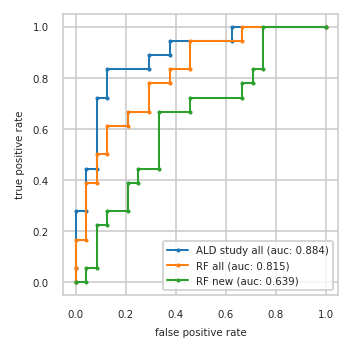

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.278  0.000 0.167  0.042 0.056
3          0.042 0.278  0.042 0.167  0.083 0.056
4          0.042 0.444  0.042 0.389  0.083 0.222
5          0.083 0.444  0.083 0.389  0.125 0.222
6          0.083 0.722  0.083 0.500  0.125 0.278
7          0.125 0.722  0.125 0.500  0.208 0.278
8          0.125 0.833  0.125 0.611  0.208 0.389
9          0.292 0.833  0.208 0.611  0.250 0.389
10         0.292 0.889  0.208 0.667  0.250 0.444
11         0.375 0.889  0.292 0.667  0.333 0.444
12         0.375 0.944  0.292 0.778  0.333 0.667
13         0.625 0.944  0.375 0.778  0.458 0.667
14         0.625 1.000  0.375 0.833  0.458 0.722
15         1.000 1.000  0.458 0.833  0.667 0.722
16           NaN   NaN  0.458 0.944  0.667 0.778
17           NaN   NaN  0.667 0.944  0.708 0.778
18           NaN   NaN  0.667 1.000  0.708 0.833
19           NaN   NaN  1.000 1.000  0.750 0.833
20           NaN   NaN    NaN   NaN  0.750 1.000
21           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,P09960;P09960-4,P09382,P16519;P16519-3
2,A0A075B6J9,C9JIZ6;P07602;P07602-2;P07602-3,P30479;Q04826
3,P61981,P10636-2;P10636-6,Q96GD0
4,P04075,F8WE04;P04792,Q504Y2
5,Q02818,P04075,J3KSJ8;Q9UD71;Q9UD71-2
6,P14174,P14174,P51688
7,Q9Y2T3;Q9Y2T3-3,Q14894,P31321
8,P00338;P00338-3,P61981,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


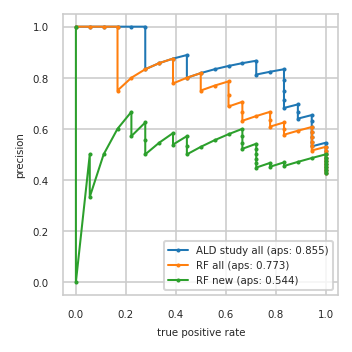

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.515 0.944     0.455 0.833
10         0.531 0.944     0.531 0.944     0.469 0.833
11         0.548 0.944     0.548 0.944     0.452 0.778
12         0.567 0.944     0.567 0.944     0.467 0.778
13         0.586 0.944     0.586 0.944     0.448 0.722
14         0.607 0.944     0.607 0.944     0.464 0.722
15         0.630 0.944     0.593 0.889     0.481 0.722
16         0.654 0.944     0.577 0.833     0.500 0.722
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.714 0.833     0.667 0.778     0.571 0.667
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.789 0.833     0.632 0.667     0.579 0.611
24         0.833 0.833     0.667 0.667     0.556 0.556
25         0.824 0.778     0.706 0.667     0.529 0.500
26         0.812 0.722     0.688 0.611     0.500 0.444
27         0.867 0.722     0.733 0.611     0.533 0.444
28         0.857 0.667     0.786 0.611     0.571 0.444
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.833 0.556     0.750 0.500     0.583 0.389
31         0.818 0.500     0.818 0.500     0.545 0.333
32         0.800 0.444     0.800 0.444     0.500 0.278
33         0.889 0.444     0.778 0.389     0.556 0.278
34         0.875 0.389     0.875 0.389     0.625 0.278
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


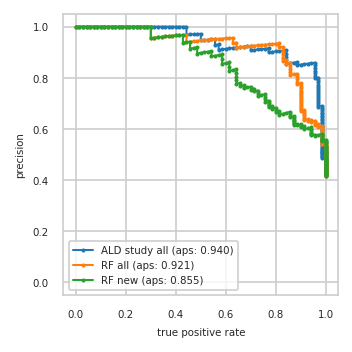

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


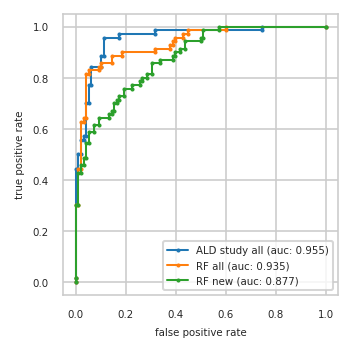

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}